# SNiFi: Logistic Regression in Binary Classification

In [3]:
import pandas as pd
import numpy as np
import os
import sys
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
from collections import Counter
import joblib

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

RANDOM_STATE = 42

ML_DIR = os.path.abspath(os.path.join(os.getcwd(), '..'))
DATASET_DIRECTORY = os.path.join(ML_DIR, 'data', 'production', 'csv')
MODEL_PATH = os.path.join(ML_DIR, 'models', 'logistic_regression_model.pkl')

X_columns = [
    'flow_duration', 'Header_Length', 'Protocol Type', 'Duration',
    'Rate', 'Srate', 'Drate', 'fin_flag_number', 'syn_flag_number',
    'rst_flag_number', 'psh_flag_number', 'ack_flag_number',
    'ece_flag_number', 'cwr_flag_number', 'ack_count',
    'syn_count', 'fin_count', 'urg_count', 'rst_count', 
    'HTTP', 'HTTPS', 'DNS', 'Telnet', 'SMTP', 'SSH', 'IRC', 'TCP',
    'UDP', 'DHCP', 'ARP', 'ICMP', 'IPv', 'LLC', 'Tot sum', 'Min',
    'Max', 'AVG', 'Std', 'Tot size', 'IAT', 'Number', 'Magnitue',
    'Radius', 'Covariance', 'Variance', 'Weight'
]
y_column = 'label'

df_sets = [k for k in os.listdir(DATASET_DIRECTORY) if k.endswith('.csv')]
df_sets.sort()
training_sets = df_sets[:int(len(df_sets) * .8)]
test_sets = df_sets[int(len(df_sets) * .8):]

dict_2classes = {
    'DDoS-RSTFINFlood': 'Attack',
    'DDoS-PSHACK_Flood': 'Attack',
    'DDoS-SYN_Flood': 'Attack',
    'DDoS-UDP_Flood': 'Attack',
    'DDoS-TCP_Flood': 'Attack',
    'DDoS-ICMP_Flood': 'Attack',
    'DDoS-SynonymousIP_Flood': 'Attack',
    'DDoS-ACK_Fragmentation': 'Attack',
    'DDoS-UDP_Fragmentation': 'Attack',
    'DDoS-ICMP_Fragmentation': 'Attack',
    'DDoS-SlowLoris': 'Attack',
    'DDoS-HTTP_Flood': 'Attack',
    'DoS-UDP_Flood': 'Attack',
    'DoS-SYN_Flood': 'Attack',
    'DoS-TCP_Flood': 'Attack',
    'DoS-HTTP_Flood': 'Attack',
    'Mirai-greeth_flood': 'Attack',
    'Mirai-greip_flood': 'Attack',
    'Mirai-udpplain': 'Attack',
    'Recon-PingSweep': 'Attack',
    'Recon-OSScan': 'Attack',
    'Recon-PortScan': 'Attack',
    'VulnerabilityScan': 'Attack',
    'Recon-HostDiscovery': 'Attack',
    'DNS_Spoofing': 'Attack',
    'MITM-ArpSpoofing': 'Attack',
    'BenignTraffic': 'Benign',
    'BrowserHijacking': 'Attack',
    'Backdoor_Malware': 'Attack',
    'XSS': 'Attack',
    'Uploading_Attack': 'Attack',
    'SqlInjection': 'Attack',
    'CommandInjection': 'Attack',
    'DictionaryBruteForce': 'Attack'
}

scaler = StandardScaler()
for train_set in tqdm(training_sets):
    file_path = os.path.join(DATASET_DIRECTORY, train_set)
    scaler.fit(pd.read_csv(file_path)[X_columns])

logistic_model = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)

for train_set in tqdm(training_sets):
    file_path = os.path.join(DATASET_DIRECTORY, train_set)
    d = pd.read_csv(file_path)
    d[X_columns] = scaler.transform(d[X_columns])
    d[y_column] = [dict_2classes[k] for k in d[y_column]]
    logistic_model.fit(d[X_columns], d[y_column])

joblib.dump(logistic_model, MODEL_PATH)

y_test = []
y_pred = []

for test_set in tqdm(test_sets):
    file_path = os.path.join(DATASET_DIRECTORY, test_set)
    d_test = pd.read_csv(file_path)
    d_test[X_columns] = scaler.transform(d_test[X_columns])
    d_test[y_column] = [dict_2classes[k] for k in d_test[y_column]]
    y_test += list(d_test[y_column].values)
    y_pred += list(logistic_model.predict(d_test[X_columns]))

print('##### Logistic Regression (2 classes) #####')
print('accuracy_score: ', accuracy_score(y_pred, y_test))
print('recall_score: ', recall_score(y_pred, y_test, average='macro'))
print('precision_score: ', precision_score(y_pred, y_test, average='macro'))
print('f1_score: ', f1_score(y_pred, y_test, average='macro'))

class_counts = Counter(y_test)
print("\nClass Imbalance:")
for label, count in class_counts.items():
    print(f"{label}: {count}")

100%|██████████| 34/34 [00:27<00:00,  1.23it/s]


##### Logistic Regression (2 classes) #####
accuracy_score:  0.9890510408880481
recall_score:  0.8903256738863513
precision_score:  0.8641187549527014
f1_score:  0.8767412604444338

Class Imbalance:
Attack: 10096839
Benign: 243322


In [4]:
cm = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:\n', cm)
print("\n\n")

Confusion Matrix:
 [[10048588    48251]
 [   64963   178359]]





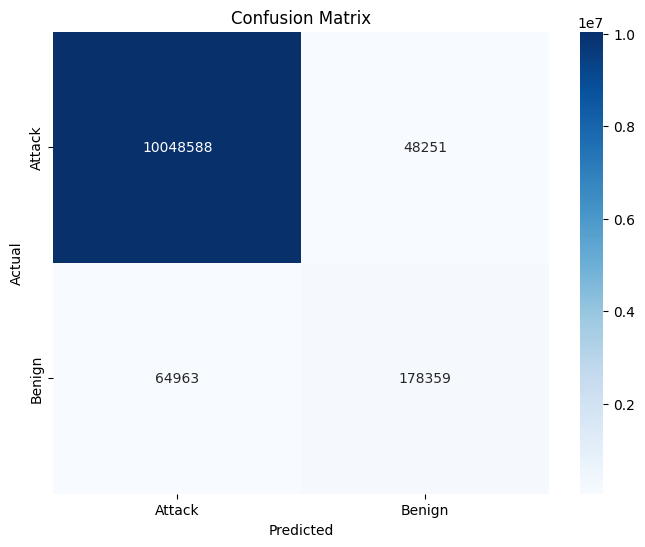

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

labels = ['Attack', 'Benign']
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### Overall Effectiveness of the Logistic Regression Model (Metric: *accuracy*)
* The model rarely makes mistakes.
* In **98.91%** of cases, it correctly identifies the type of traffic (**attack** or **normal traffic**).

### How Well the Model Detects Attacks (Metric: *Recall*)
* The model is highly capable of identifying attack attempts, with a recall of over **89%**.

### How Well the Model Avoids False Alarms (Metric: *Precision*)
* The model performs very well in avoiding false alarms, with a precision of over **86%**.

### Balance Between Detection and Avoiding False Alarms (Metric: *F1 Score*)
* The **F1 score**, which helps understand how well the model balances detecting attacks and avoiding false alarms, is over **87.67%**.
* This high F1 score indicates a strong balance between these two aspects: the model is equally good at detecting attacks and avoiding false alarms.

### Confusion Matrix Analysis
The confusion matrix shows how often the model makes errors or is accurate in its predictions. For this model:
* **Correctly** identified **10,048,588** attacks as threats <-- **True Positives (TP)**.
* **Incorrectly** identified **64,963** benign activities as attacks (false alarms) <-- **False Positives (FP)**.
* **Incorrectly** classified **48,251** attacks as safe activities (these are misses) <-- **False Negatives (FN)**.
* **Correctly** recognized **178,359** benign activities as safe activities <-- **True Negatives (TN)**.